Lambda School Data Science

*Unit 2, Sprint 2, Module 2*

---

In [1]:
%%capture
import sys

# If you're on Colab:
if 'google.colab' in sys.modules:
    DATA_PATH = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Kaggle-Challenge/main/data/'
    !pip install category_encoders==2.*
    !pip install pandas-profiling==2.*

# If you're working locally:
else:
    DATA_PATH = '../data/'

In [2]:
def color_percent(floaty):
  "Input a normalized number between 0 and 1, and get it in string form colored according to percentage."
  if floaty >= .5:
    green = 200
    red = int(500 * (1 - floaty))
  else:
    red = 255
    green = int(400 * floaty)

  return f'\033[38;2;{red};{green};0m{floaty}\033[00m'

# Module Project: Random Forests

This week, the module projects will focus on creating and improving a model for the Tanazania Water Pump datset. Your goal is to create a model to predict whether a water pump is functional, non-functional, or needs repair.

Dataset source: [DrivenData.org](https://www.drivendata.org/competitions/7/pump-it-up-data-mining-the-water-table/).

## Directions

The tasks for this project are as follows:

- **Task 1:** Sign up for a [Kaggle](https://www.kaggle.com/) account.
- **Task 2:** Use `wrangle` function to import training and test data.
- **Task 3:** Split training data into feature matrix `X` and target vector `y`.
- **Task 4:** Split feature matrix `X` and target vector `y` into training and test sets.
- **Task 5:** Establish the baseline accuracy score for your dataset.
- **Task 6:** Build and train `model_dt`.
- **Task 7:** Calculate the training and validation accuracy score for your model.
- **Task 8:** Adjust model's `max_depth` to reduce overfitting.
- **Task 9 `stretch goal`:** Create a horizontal bar chart showing the 10 most important features for your model.

You should limit yourself to the following libraries for this project:

- `category_encoders`
- `matplotlib`
- `pandas`
- `pandas-profiling`
- `sklearn`

# I. Wrangle Data

In [5]:
import pandas as pd

def wrangle(fm_path, tv_path=None):
    if tv_path:
        df = pd.merge(pd.read_csv(fm_path, 
                                  na_values=[0, -2.000000e-08]),
                      pd.read_csv(tv_path)).set_index('id')
    else:
        df = pd.read_csv(fm_path, 
                         na_values=[0, -2.000000e-08],
                         index_col='id')

    # Drop constant columns
    df.drop(columns=['recorded_by'], inplace=True)

    # Drop HCCCs
    cutoff = 100
    drop_cols = [col for col in df.select_dtypes('object').columns
                 if df[col].nunique() > cutoff]
    df.drop(columns=drop_cols, inplace=True)

    # Drop duplicate columns
    dupe_cols = [col for col in df.head(15).T.duplicated().index
                 if df.head(15).T.duplicated()[col]]
    df.drop(columns=dupe_cols, inplace=True)             

    return df

**Task 1:** Sign up for a [Kaggle](https://www.kaggle.com/) account. Choose a username that's based on your real name. Like GitHub, Kaggle is part of your public profile as a data scientist.

**Task 2:** Modify the `wrangle` function to engineer a `'pump_age'` feature. Then use the function to read `train_features.csv` and `train_labels.csv` into the DataFrame `df`, and `test_features.csv` into the DataFrame `X_test`.

In [6]:
df = wrangle('train_features.csv', 'train_labels.csv')
X_test = wrangle('test_features.csv')

# II. Split Data

**Task 3:** Split your DataFrame `df` into a feature matrix `X` and the target vector `y`. You want to predict `'status_group'`.

In [7]:
target = 'status_group'
X = df.drop(columns=target)
y = df[target]

**Task 4:** Using a randomized split, divide `X` and `y` into a training set (`X_train`, `y_train`) and a validation set (`X_val`, `y_val`).

In [10]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# III. Establish Baseline

**Task 5:** Since this is a **classification** problem, you should establish a baseline accuracy score. Figure out what is the majority class in `y_train` and what percentage of your training observations it represents.

In [11]:
baseline_acc = y_train.value_counts(normalize=True).max()
print('Baseline Accuracy Score:', color_percent(baseline_acc))

Baseline Accuracy Score: 0.5425489938182296


# IV. Build Model

**Task 6:** Build a `Pipeline` named `model_rf`, and fit it to your training data. Your `Pipeline` should include:

- an `OrdinalEncoder` transformer for categorical features.
- a `SimpleImputer` transformer fot missing values.
- a `RandomForestClassifier` predictor.

**Note:** Don't forget to set the `random_state` parameter for your `RandomForestClassifier`. Also, to decrease training time, set `n_jobs` to `-1`.

In [85]:
from sklearn.pipeline import make_pipeline
from category_encoders import OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier

model_rf = make_pipeline(
    OrdinalEncoder(),
    SimpleImputer(strategy='mean'),
    RandomForestClassifier(
        n_jobs=-1,
        random_state=42,
        n_estimators=90,
        max_depth=19
        # max_samples=.6
    )
)
model_rf.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('ordinalencoder',
                 OrdinalEncoder(cols=['basin', 'region', 'public_meeting',
                                      'scheme_management', 'permit',
                                      'extraction_type',
                                      'extraction_type_class', 'management',
                                      'management_group', 'payment',
                                      'payment_type', 'water_quality',
                                      'quality_group', 'quantity', 'source',
                                      'source_type', 'source_class',
                                      'waterpoint_type'],
                                drop_invariant=False,...
                 RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                        class_weight=None, criterion='gini',
                                        max_depth=19, max_features='auto',
                                        m

# V. Check Metrics

**Task 7:** Calculate the training and validation accuracy scores for `model_rf`.

In [86]:
from sklearn.metrics import accuracy_score

training_acc = accuracy_score(y_train, model_rf.predict(X_train))
val_acc = accuracy_score(y_val, model_rf.predict(X_val))

print('Training Accuracy Score:', color_percent(training_acc))
print('Validation Accuracy Score:', color_percent(val_acc))

Training Accuracy Score: 0.9378666315927923
Validation Accuracy Score: 0.8006102693602694


# VI. Tune Model

**Task 8:** Tune `n_estimators` and `max_depth` hyperparameters for your `RandomForestClassifier` to get the best validation accuracy score for `model_rf`. 

In [43]:
# Use this cell to experiment and then change 
# your model hyperparameters in Task 6

n_scores = []
# 0 n_estimator
# 1 train acc
# 2 val acc

for x in range(85, 95, 1):
  model = make_pipeline(
      OrdinalEncoder(),
      SimpleImputer(strategy='mean'),
      RandomForestClassifier(
          n_jobs=-1,
          random_state=42,
          n_estimators=x
      )
  )
  model.fit(X_train, y_train)

  trainAcc = accuracy_score(y_train, model.predict(X_train))
  valAcc = accuracy_score(y_val, model.predict(X_val))

  n_scores.append((x, trainAcc, valAcc))

In [44]:
def best_score(score_list):

  def score_sort(e):
    test = round(e[2], 4) * 10000 + e[1]
    return test

  listy = score_list.copy()
  listy.sort(key=score_sort, reverse=True)
  return listy[0][0]

best_score(n_scores) # 90 is best

90

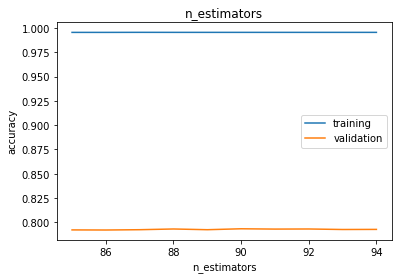

In [45]:
import matplotlib.pyplot as plt

def graphify(data):
  tests = [x[0] for x in data]
  train = [x[1] for x in data]
  val = [x[2] for x in data]

  return tests, train, val

tests, train, val = graphify(n_scores)

plt.title('n_estimators')
plt.plot(tests, train, label='training')
plt.plot(tests, val, label='validation')
plt.xlabel('n_estimators')
plt.ylabel('accuracy')
plt.legend()
plt.show()

In [50]:
mv_scores = []
# 0 max_depth
# 1 train acc
# 2 val acc

for x in range(17, 23, 1):
  model = make_pipeline(
      OrdinalEncoder(),
      SimpleImputer(strategy='mean'),
      RandomForestClassifier(
          n_jobs=-1,
          random_state=42,
          n_estimators=90,
          max_depth=x
      )
  )
  model.fit(X_train, y_train)

  trainAcc = accuracy_score(y_train, model.predict(X_train))
  valAcc = accuracy_score(y_val, model.predict(X_val))

  mv_scores.append((x, trainAcc, valAcc))

In [51]:
best_score(mv_scores) # 19 is best

19

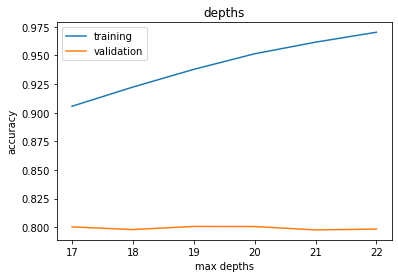

In [52]:
tests, train, val = graphify(mv_scores)

plt.title('depths')
plt.plot(tests, train, label='training')
plt.plot(tests, val, label='validation')
plt.xlabel('max depths')
plt.ylabel('accuracy')
plt.legend()
plt.show()

In [68]:
ms_scores = []
# 0 max_depth
# 1 train acc
# 2 val acc

for x in range(1, 10, 1):
  model = make_pipeline(
      OrdinalEncoder(),
      SimpleImputer(strategy='mean'),
      RandomForestClassifier(
          n_jobs=-1,
          random_state=42,
          n_estimators=90,
          max_depth=19,
          max_samples=x/10
      )
  )
  model.fit(X_train, y_train)

  trainAcc = accuracy_score(y_train, model.predict(X_train))
  valAcc = accuracy_score(y_val, model.predict(X_val))

  ms_scores.append((x/10, trainAcc, valAcc))

In [69]:
best_score(ms_scores)

0.6

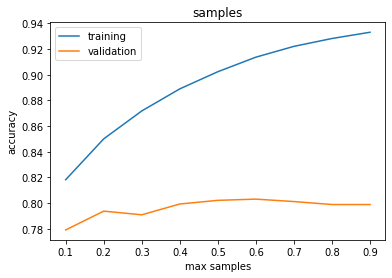

In [70]:
tests, train, val = graphify(ms_scores)

plt.title('samples')
plt.plot(tests, train, label='training')
plt.plot(tests, val, label='validation')
plt.xlabel('max samples')
plt.ylabel('accuracy')
plt.legend()
plt.show()

# VII. Communicate Results

**Task 9:** Generate a list of predictions for `X_test`. The list should be named `y_pred`.

In [ ]:
X_test.drop(columns=['waterpoint_type_group'], inplace=True)

In [83]:
y_pred = pd.DataFrame(data=model_rf.predict(X_test), index=X_test.index)
y_pred.columns = ['status_group']

assert len(y_pred) == len(X_test), f'Your list of predictions should have {len(X_test)} items in it. '

**Task 11 `stretch goal`:** Create a DataFrame `submission` whose index is the same as `X_test` and that has one column `'status_group'` with your predictions. Next, save this DataFrame as a CSV file and upload your submissions to our competition site. 

**Note:** Check the `sample_submission.csv` file on the competition website to make sure your submissions follows the same formatting. 

In [84]:
submission = y_pred

submission.to_csv('new_submission(1).csv')